# ===== 1. Loading Data =====

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = '/content/drive/MyDrive/Oral Dose Forms.zip'
extract_to = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# ===== 2. Import Libraries =====

In [3]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 61.1 MB/s eta 0:00:00


In [4]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import faiss
import base64
from io import BytesIO
from sklearn.decomposition import PCA
from datetime import datetime
from google.colab import files

# ===== 3. Configuration Settings =====

In [5]:
# Path to image folder (adjust as needed)
image_folder = "/content/data/Oral Dose Forms"
results_folder = 'results'
os.makedirs(results_folder, exist_ok=True)
os.makedirs(image_folder, exist_ok=True)

In [6]:
# Model settings
model_type = 'alexnet'
use_gpu = True

In [7]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Count images
image_filenames = [
    f for f in os.listdir(image_folder)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]
print(f"Total images: {len(image_filenames)}")

Total images: 25988


# ===== 4. Create Model for Feature Extraction =====

In [9]:
# Setup feature extraction model (using AlexNet)
base_model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
# Remove the final fully connected layer (classifier[-1])
model = nn.Sequential(
    base_model.features,  # Take the convolutional part of AlexNet
    nn.AdaptiveAvgPool2d((6, 6)),  # AlexNet's avgpool layer
    nn.Flatten()  # Flatten the output
)

# Setup transforms for AlexNet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model = model.to(device)
model.eval()
print(f"Model {model_type} loaded successfully.")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 156MB/s]


Model alexnet loaded successfully.


# ===== 5. Extract Metadata from Filenames =====

In [10]:
print("Extracting metadata from filenames...")

# Function to extract metadata
def extract_metadata(filename):
    base = filename.rsplit('.', 1)[0]

    # Extract medication name (everything before first parenthesis or digit)
    name_match = re.match(r"([^\(\[\d]+)", base)
    medication_name = name_match.group(1).strip() if name_match else "Unknown"

    # Extract dosage
    dosage_match = re.search(r"\b(\d+(?:\.\d+)?\s*(?:mg|mcg|g|ml))\b", base.lower())
    dosage = dosage_match.group(1).replace(" ", "") if dosage_match else "Unknown"

    # Extract form
    form = "Unknown"
    if "chewable" in base.lower():
        form = "Chewable Tablet"
    elif "sol tab" in base.lower() or "tab" in base.lower() or "tablet" in base.lower():
        form = "Tablet"
    elif "cap" in base.lower() or "capsule" in base.lower():
        form = "Capsule"
    elif "injection" in base.lower() or "iv" in base.lower() or "syringe" in base.lower():
        form = "Injection"
    elif "oral suspension" in base.lower() or "syrup" in base.lower() or "liquid" in base.lower() or "susp" in base.lower():
        form = "Oral Suspension"
    elif "pill" in base.lower():
        form = "Pill"

    return {
        "Medication Name": medication_name,
        "Dosage": dosage,
        "Form": form,
        "Image Filename": filename
    }

# Process all filenames
data = [extract_metadata(f) for f in tqdm(image_filenames)]
metadata_df = pd.DataFrame(data)

# Save CSV
output_file = os.path.join(results_folder, "medication_metadata.csv")
metadata_df.to_csv(output_file, index=False)
print(f"Saved metadata to {output_file} with {len(metadata_df)} entries.")


Extracting metadata from filenames...


100%|██████████| 25988/25988 [00:00<00:00, 253814.31it/s]


Saved metadata to results/medication_metadata.csv with 25988 entries.


In [11]:
# Display metadata
print("\nMetadata Preview:")
display(metadata_df.head())


Metadata Preview:


,Medication Name,Dosage,Form,Image Filename
0,Dydrogesterone,10mg,Tablet,Dydrogesterone (Duphaston) 10mg Tab_0_aug_2.jpg
1,Cetirizine,5mg,Oral Suspension,Cetirizine (Sunizine) Syrup 5mg in 5ml [19July...
2,Nadolol,40mg,Tablet,Nadolol (APO-bottle) 40mg Tab (MA&mfr_Apotex I...
3,Ropinirole,0.25mg,Tablet,Ropinirole (Requip-Box) 0.25mg Tab [21Oct14]_2...
4,Bisoprolol,5mg,Tablet,Bisoprolol (BisoHexal Germany-Box) Tab 5mg [04...


# ===== 6. Generate Image Embeddings =====

In [12]:
print("Generating embeddings for all images...")

features = []
valid_filenames = []

for filename in tqdm(image_filenames):
    try:
        # Load and transform image
        img_path = os.path.join(image_folder, filename)
        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)

        # Extract features
        with torch.no_grad():
            embedding = model(input_tensor).squeeze().cpu().numpy()
            if embedding.ndim == 0:  # Handle case of single scalar output
                embedding = np.array([embedding])

        features.append(embedding)
        valid_filenames.append(filename)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Stack features
embeddings = np.array(features)
filenames = valid_filenames

# Normalize embeddings for cosine similarity
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

print(f"Generated embeddings for {len(valid_filenames)} images with shape {embeddings.shape}")

# Save embeddings for future use
np.save(os.path.join(results_folder, "embeddings.npy"), embeddings)
with open(os.path.join(results_folder, "filenames.txt"), 'w') as f:
    for filename in valid_filenames:
        f.write(f"{filename}\n")

Generating embeddings for all images...


100%|██████████| 25988/25988 [12:39<00:00, 34.23it/s]


Generated embeddings for 25988 images with shape (25988, 9216)


# ===== 7. Build FAISS Index for Fast Similarity Search =====

In [13]:
print("Building FAISS index for fast similarity search...")
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)  # Inner product for cosine similarity with normalized vectors
index.add(embeddings)
print("FAISS index built successfully.")

Building FAISS index for fast similarity search...
FAISS index built successfully.


# ===== 8. Visualize Embeddings in 2D =====

Visualizing embeddings in 2D space using PCA...
Embedding visualization saved to results/alexnet_embeddings_2d.png


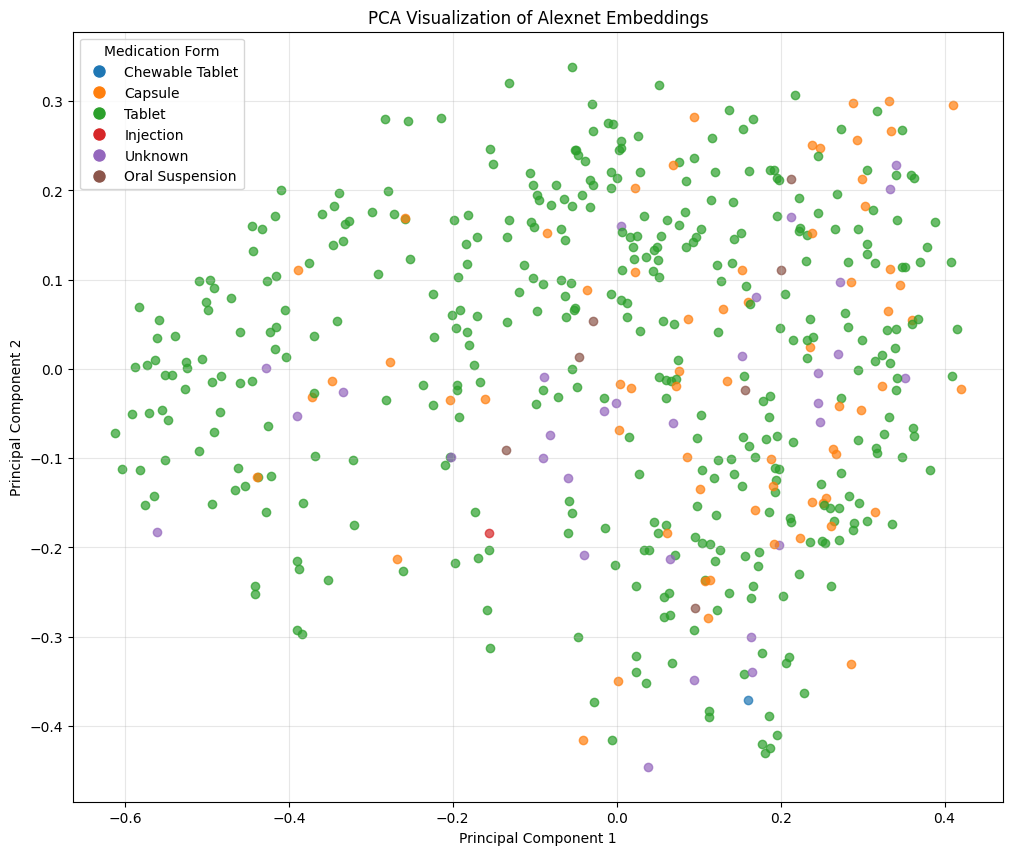

In [14]:
print("Visualizing embeddings in 2D space using PCA...")

# Number of samples to visualize
n_samples = min(500, len(embeddings))

# Subsample if needed
if n_samples >= len(embeddings):
    sample_embeddings = embeddings
    sample_filenames = filenames
else:
    # Randomly sample
    indices = np.random.choice(len(embeddings), n_samples, replace=False)
    sample_embeddings = embeddings[indices]
    sample_filenames = [filenames[i] for i in indices]

# Apply PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(sample_embeddings)

# Extract medication form for coloring
forms = [extract_metadata(f)["Form"] for f in sample_filenames]
unique_forms = list(set(forms))
form_to_color = {form: plt.cm.tab10(i % 10) for i, form in enumerate(unique_forms)}

# Create plot
plt.figure(figsize=(12, 10))

# Plot each point
for i, (x, y) in enumerate(reduced_embeddings):
    form = forms[i]
    plt.scatter(x, y, color=form_to_color[form], alpha=0.7)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=form_to_color[form], markersize=10, label=form)
                  for form in unique_forms]
plt.legend(handles=legend_elements, title="Medication Form")

# Add labels and title
plt.title(f'PCA Visualization of {model_type.capitalize()} Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(alpha=0.3)

save_path = os.path.join(results_folder, f"{model_type}_embeddings_2d.png")
plt.savefig(save_path, dpi=300)
print(f"Embedding visualization saved to {save_path}")
plt.show()

# ===== 9. Find Similar Images for a Query Image =====


Please upload a query image:


Saving Alendronic Acid (APO-box) Tab 70mg [04Sep14]_1_aug_3.jpg to Alendronic Acid (APO-box) Tab 70mg [04Sep14]_1_aug_3 (1).jpg
Saved query image to /content/data/Oral Dose Forms/Alendronic Acid (APO-box) Tab 70mg [04Sep14]_1_aug_3 (1).jpg
Visualization saved to results/similar_to_Alendronic Acid (APO-box) Tab 70mg [04Sep14]_1_aug_3 (1).png


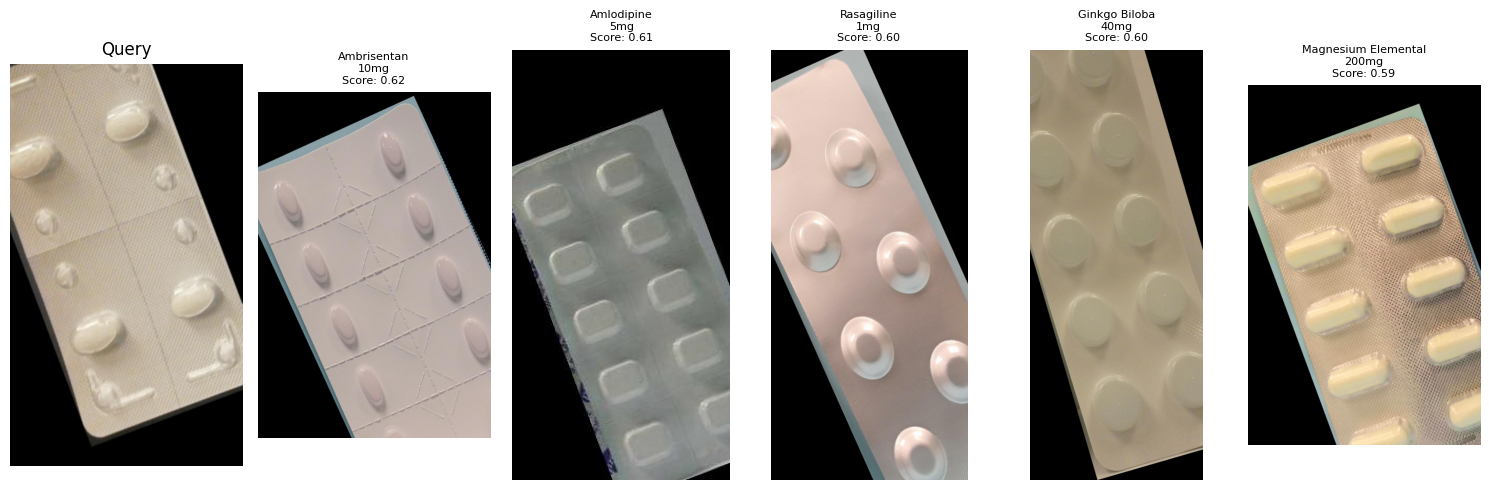

In [18]:
# Let user upload a query image
print("\nPlease upload a query image:")
query_uploads = files.upload()
query_image_path = list(query_uploads.keys())[0]

# Save the query image
query_save_path = os.path.join(image_folder, query_image_path)
with open(query_save_path, 'wb') as f:
    f.write(query_uploads[query_image_path])
print(f"Saved query image to {query_save_path}")

# Get query embedding
img = Image.open(query_save_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    query_embedding = model(input_tensor).squeeze().cpu().numpy()
    if query_embedding.ndim == 0:  # Handle case of single scalar output
        query_embedding = np.array([query_embedding])

# Normalize query embedding
query_embedding = query_embedding / np.linalg.norm(query_embedding)

# Settings for similarity search
top_k = 5
exclude_same_med = True

# Search for similar images
D, I = index.search(np.array([query_embedding]), k=top_k + 20)  # Get extra results for filtering

# Get query medication name if excluding same medications
if exclude_same_med:
    query_filename = os.path.basename(query_save_path)
    query_metadata = extract_metadata(query_filename)
    query_med_name = query_metadata["Medication Name"].lower()

# Collect results
similar_files = []
similarity_scores = []

for i, idx in enumerate(I[0]):
    if idx < len(filenames):  # Ensure index is valid
        result_filename = filenames[idx]
        result_metadata = extract_metadata(result_filename)
        result_med_name = result_metadata["Medication Name"].lower()

        # Skip if same medication and exclude_same_med is True
        if exclude_same_med and result_med_name == query_med_name:
            continue

        similar_files.append(result_filename)
        similarity_scores.append(float(D[0][i]))  # Convert to Python float

        if len(similar_files) >= top_k:
            break

similar_images = list(zip(similar_files, similarity_scores))

# Visualize similar images
# Set up plot
fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 5))

# Query image
query_img = Image.open(query_save_path)
axes[0].imshow(query_img)
axes[0].set_title("Query")
axes[0].axis("off")

# Similar images
for i, (img_name, score) in enumerate(similar_images):
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path)
    axes[i + 1].imshow(img)

    # Show metadata
    metadata = extract_metadata(img_name)
    title = f"{metadata['Medication Name']}\n{metadata['Dosage']}\nScore: {score:.2f}"
    axes[i + 1].set_title(title, fontsize=8)
    axes[i + 1].axis("off")

# Fill empty subplots if fewer than top_k results
for i in range(len(similar_images) + 1, top_k + 1):
    axes[i].axis("off")

plt.tight_layout()

# Save visualization
query_filename = os.path.basename(query_save_path)
save_path = os.path.join(results_folder, f"similar_to_{query_filename.split('.')[0]}.png")
plt.savefig(save_path, dpi=300)
print(f"Visualization saved to {save_path}")

plt.show()

In [20]:
# Function to convert image to data URI for HTML embedding
def image_to_data_uri(image_path, max_size=(150, 150), quality=70):
    """Convert image to data URI for embedding in HTML."""
    try:
        img = Image.open(image_path).convert("RGB")
        img.thumbnail(max_size)
        buffer = BytesIO()
        img.save(buffer, format="JPEG", quality=quality)
        encoded_string = base64.b64encode(buffer.getvalue()).decode("utf-8")
        data_uri = f"data:image/jpeg;base64,{encoded_string}"
        return data_uri
    except Exception as e:
        print(f"Error converting {image_path}: {e}")
        return ""

# Settings for report
threshold = 0.55
max_results_per_category = 5
query_image_paths = [query_save_path]  # You can add more query images here

# Start HTML content
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Medication Similarity Report</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 20px;
            background-color: #f5f5f5;
        }}
        .header {{
            background-color: #1a5276;
            color: white;
            padding: 20px;
            text-align: center;
            margin-bottom: 30px;
            border-radius: 5px;
        }}
        .threshold-info {{
            font-size: 16px;
            margin-bottom: 20px;
            text-align: center;
        }}
        .query-container {{
            background-color: white;
            margin-bottom: 30px;
            padding: 15px;
            border-radius: 5px;
            box-shadow: 0 2px 5px rgba(0,0,0,0.1);
        }}
        .query-header {{
            font-size: 18px;
            font-weight: bold;
            margin-bottom: 15px;
            padding-bottom: 10px;
            border-bottom: 1px solid #ddd;
        }}
        .results-row {{
            display: flex;
            flex-wrap: wrap;
            margin-bottom: 10px;
        }}
        .query-image {{
            text-align: center;
            margin-right: 20px;
            margin-bottom: 15px;
            width: 180px;
        }}
        .results-container {{
            display: flex;
            flex-wrap: wrap;
        }}
        .result-item {{
            margin: 10px;
            text-align: center;
            width: 180px;
        }}
        .result-image {{
            border: 1px solid #ddd;
            padding: 5px;
            background-color: white;
        }}
        .result-image img {{
            max-width: 150px;
            height: auto;
        }}
        .result-details {{
            font-size: 12px;
            margin-top: 5px;
        }}
        .category-header {{
            font-weight: bold;
            margin: 10px 0;
            padding: 5px;
            background-color: #eee;
            border-radius: 3px;
        }}
        .timestamp {{
            text-align: center;
            font-size: 12px;
            color: #777;
            margin-top: 20px;
        }}
    </style>
</head>
<body>
    <div class="header">
        <h1>Medication Image Similarity Report</h1>
        <p>Model: {model_type.capitalize()} | Similarity Threshold: {threshold}</p>
    </div>
"""

# Process each query image
for query_path in query_image_paths:
    query_filename = os.path.basename(query_path)
    query_metadata = extract_metadata(query_filename)

    # Load and transform query image
    img = Image.open(query_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Extract query embedding
    with torch.no_grad():
        query_embedding = model(input_tensor).squeeze().cpu().numpy()
        if query_embedding.ndim == 0:
            query_embedding = np.array([query_embedding])

    # Normalize query embedding
    query_embedding = query_embedding / np.linalg.norm(query_embedding)

    # Calculate similarity with all embeddings
    similarities = np.dot(embeddings, query_embedding)

    # Get indices where similarity is above threshold
    indices = np.where(similarities >= threshold)[0]

    # Group results by category
    results_by_category = {}
    for idx in indices:
        if idx < len(filenames):
            result_filename = filenames[idx]
            result_metadata = extract_metadata(result_filename)
            result_category = result_metadata["Form"]

            # Skip if it's the same file as the query
            if result_filename == query_filename:
                continue

            result_info = {
                "filename": result_filename,
                "metadata": result_metadata,
                "similarity": float(similarities[idx])
            }

            if result_category not in results_by_category:
                results_by_category[result_category] = []

            results_by_category[result_category].append(result_info)

    # Sort results by similarity within each category
    for category in results_by_category:
        results_by_category[category] = sorted(
            results_by_category[category],
            key=lambda x: x["similarity"],
            reverse=True
        )[:max_results_per_category]

    # Add query container
    html_content += f"""
    <div class="query-container">
        <div class="query-header">Query: {query_metadata["Medication Name"]} {query_metadata["Dosage"]} ({query_metadata["Form"]})</div>
        <div class="results-row">
            <div class="query-image">
                <img src="{image_to_data_uri(query_path)}" alt="Query Image"><br>
                <div class="result-details">{query_filename}</div>
            </div>
            <div class="results-container">
    """

    # Add results for each category
    for category, results in results_by_category.items():
        if results:
            html_content += f"""
                <div style="width: 100%;">
                    <div class="category-header">{category} ({len(results)} results)</div>
                </div>
            """

            for result in results:
                result_path = os.path.join(image_folder, result["filename"])
                html_content += f"""
                <div class="result-item">
                    <div class="result-image">
                        <img src="{image_to_data_uri(result_path)}" alt="Result Image">
                    </div>
                    <div class="result-details">
                        {result["metadata"]["Medication Name"]}<br>
                        {result["metadata"]["Dosage"]}<br>
                        Similarity: {result["similarity"]:.4f}
                    </div>
                </div>
                """

    html_content += """
            </div>
        </div>
    </div>
    """

# Add timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
html_content += f"""
    <div class="timestamp">Report generated on {timestamp}</div>
</body>
</html>
"""

# Save HTML file
report_path = os.path.join(results_folder, f"similarity_report_{model_type}_{int(threshold*100)}.html")
with open(report_path, "w", encoding="utf-8") as f:
    f.write(html_content)

print(f"HTML report saved to {report_path}")

# Download report (enable this in Colab)
files.download(report_path)

HTML report saved to results/similarity_report_alexnet_55.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ===== 10. Generate HTML Report =====
